In [30]:
import pandas as pd
import tushare as ts
import numpy as np
import matplotlib.pyplot as plt
"""
Step 1
Prepare minutes price data
"""
# 1.1 Read data
input_path = 'data/三家银行A H分钟收盘价.xlsx'
# converter = dict(zip(['600036.SH', '招商银行','工商银行','农业银行','3968.HK','招商银行.1','工商银行.1','农业银行.1'], [str,float,float,float,str,float,float,float]))
df_input = pd.read_excel(input_path,converters={'600036.SH':str, '3968.HK':str})


In [44]:
# 1.2 Segment time str
df_AH= pd.merge(df_input[['600036.SH', '招商银行','工商银行','农业银行']].drop([0,1]).dropna(), \
    df_input[['3968.HK','招商银行.1','工商银行.1','农业银行.1']].drop([0,1]).dropna(), \
        how='inner',left_on='600036.SH', right_on='3968.HK').drop('3968.HK',axis=1).rename(columns= {'600036.SH':'date'})
df_date = df_AH['date'].str.split(' ',expand=True).rename(columns={0:'date', 1:'time'})
df_AH['date'] = df_date['date'].str.replace('-','')
df_AH['time'] = df_date['time']
df_AH[['招商银行','工商银行','农业银行','招商银行.1','工商银行.1','农业银行.1']] = df_AH[['招商银行','工商银行','农业银行','招商银行.1','工商银行.1','农业银行.1']].astype(float)

# 1.3 Exchage rate collected
pro = ts.pro_api('00d803b166f55fc30c178d74c158985136010d6bd19271b182059eef')
start_date = '2021-01-04'
end_date = '2022-02-25'
df_CNY = pro.fx_daily(ts_code='USDCNH.FXCM', start_date=start_date, end_date=end_date).iloc[::-1].reset_index(drop=True)
df_HKD = pro.fx_daily(ts_code='USDHKD.FXCM', start_date=start_date, end_date=end_date).iloc[::-1].reset_index(drop=True)
ER_feature_list = ['trade_date', 'ask_close']
# Exchage Rate
df_ER = df_CNY[ER_feature_list].rename(columns={'ask_close':'CNY2USD'}).merge(df_HKD[ER_feature_list].rename(columns={'ask_close':'HKD2USD'}))
df_AH = pd.merge(df_AH, df_ER, left_on='date', right_on='trade_date', how='left').dropna().drop('trade_date',axis=1)

# 1.4 Uniform measuring unit to USD
df_AH['招商银行'] = df_AH['招商银行'] / df_AH['CNY2USD']
df_AH['招商银行.1'] = df_AH['招商银行.1'] / df_AH['HKD2USD']
df_AH['工商银行'] = df_AH['工商银行'] / df_AH['CNY2USD']
df_AH['工商银行.1'] = df_AH['工商银行.1'] / df_AH['HKD2USD']
df_AH['农业银行'] = df_AH['农业银行'] / df_AH['CNY2USD']
df_AH['农业银行.1'] = df_AH['农业银行.1'] / df_AH['HKD2USD']
df_AH.to_excel('data/df_AH.xlsx')

In [74]:
class stock:
    def __init__(self, name, df_AH):
        self.name = name
        self.df_AH = df_AH
        self.df_AH.columns = ['A','H']
        self.rolling_window_size = 60
        self.df_AH['DR'] =1 - (self.df_AH['H'])/self.df_AH['A']
        self.df_AH['DR_mean'] = self.df_AH['DR'].rolling(self.rolling_window_size).mean()
        self.df_AH['DR_std'] = self.df_AH['DR'].rolling(self.rolling_window_size).std()
        self.df_AH['DR_ub'] = self.df_AH['DR_mean']+self.df_AH['DR_std'] * 1
        self.df_AH['DR_lb'] = self.df_AH['DR_mean']-self.df_AH['DR_std'] * 0.5
        
    def draw_price(self, save_path=''):
        plt.plot(self.df_AH.dropna()['A'],linewidth=1,label='A')
        plt.plot(self.df_AH.dropna()['H'],linewidth=1,label='HK')
        plt.legend()
        plt.title(self.name)
        if save_path != '':
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            plt.savefig(save_path+ '/' + self.name + 'price.png',dpi=600, bbox_inches='tight')
        plt.show()
    
    def draw_DR(self, save_path=''):
        plt.plot(self.df_AH.dropna()['DR'], color='steelblue', label='DiscountRate',linewidth=0.8)
        plt.plot(self.df_AH.dropna()['DR_mean'], color='orange', label='Mean')
        plt.plot(self.df_AH.dropna()['DR_ub'], color='orange',linestyle='--', label='ub')
        plt.plot(self.df_AH.dropna()['DR_lb'], color='orange',linestyle='--', label='lb')
        plt.legend()
        plt.title(self.name + '\nDiscount Rate')
        if save_path != '':
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            plt.savefig(save_path + '/' + self.name + 'DR.png',dpi=600, bbox_inches='tight')
        plt.show()

    def trading_rule(self, psntValue=100,show_transaction=False,save_path=''):
        # extract data
        df = self.df_AH
        df = df.dropna(how='any')
        close = df['H'].values
        open = df['H'].values
        ub = df['DR_ub'].values
        lb = df['DR_lb'].values
        DR = df['DR'].values
        n = len(df)
        # initialize state
        value = np.zeros(n)
        buyPoint = np.zeros(n)
        sellPoint = np.zeros(n)
        psntVolm = psntValue/open[0]
        isAllIn = True
        isSell = False
        isBuy = False
        for t in range(n):
            # cal present value
            if isAllIn:
                psntValue = psntVolm * open[t]
            value[t] = psntValue
            # no operation
            if not (isBuy or isSell):
                if DR[t] < lb[t] and isAllIn:
                    isSell = True
                    # all in
                elif DR[t] > ub[t] and not isAllIn:
                    # all out
                    isBuy = True
            # operation
            elif isBuy:
                buyPoint[t] = 1
                isBuy = False
                psntVolm = psntValue/open[t]
                isAllIn = True
            else:# sell
                sellPoint[t] = 1
                isSell = False
                isAllIn = False
        # value, psntValue, buyPoint, sellPoint = trading_rule(df_AH)

        plt.plot(value, label='Value',linewidth=1)
        if show_transaction:
            plt.scatter(np.arange(len(value))[buyPoint == 1],value[buyPoint == 1],color='red',label='Buy',s=1)
            plt.scatter(np.arange(len(value))[sellPoint == 1],value[sellPoint == 1],color='green',label='Sell',s=1)
        plt.legend()
        plt.title(self.name + '\nFinal Value: {:.2f}'.format(psntValue))
        if save_path != '':
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            plt.savefig(save_path+ '/' + self.name + 'value.png',dpi=600, bbox_inches='tight')
        plt.show()
        # return value, psntValue, buyPoint, sellPoint

In [75]:
stock1 = stock('招商银行',df_AH=df_AH[['招商银行','招商银行.1']])
# df_AH[['招商银行','招商银行.1']].rename(columns={'招商银行':'A', 1:'H'})

              A         H
0      6.449892  6.158001
1      6.394003  6.151553
2      6.395513  6.099967
3      6.366814  6.099967
4      6.369835  6.074175
...         ...       ...
56623  7.659205  7.765917
56624  7.654492  7.765917
56625  7.654492  7.765917
56626  7.654492  7.765917
56627  7.652921  7.765917

[56628 rows x 2 columns]


/Users/kuzaowuwei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/kuzaowuwei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/kuzaowuwei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

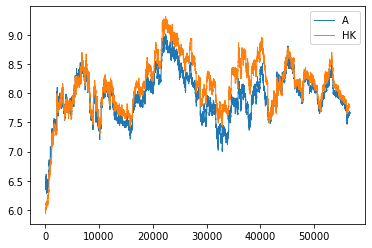

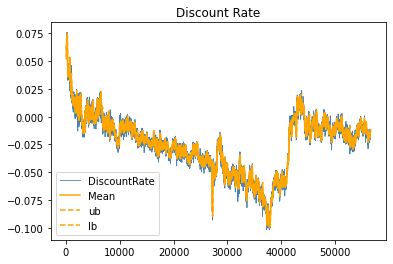

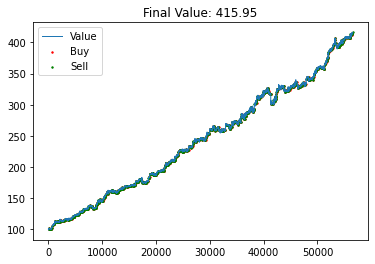

In [76]:
stock1.draw_price()
stock1.draw_DR()
stock1.trading_rule()

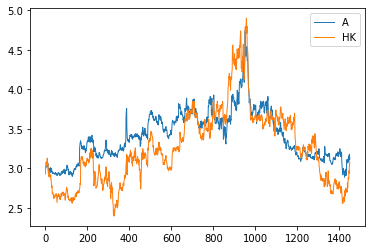

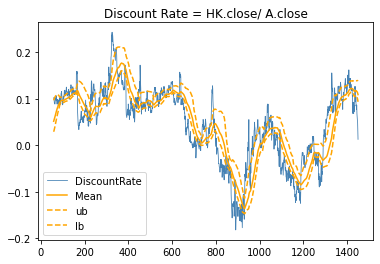

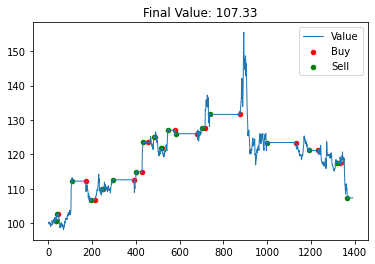

In [79]:
import pandas as pd
import tushare as ts
import numpy as np
import matplotlib.pyplot as plt


plt.plot(df_AH.dropna()['close_x'],linewidth=1,label='A')
plt.plot(df_AH.dropna()['close_y'],linewidth=1,label='HK')
plt.legend()
plt.savefig('data/股价对比时序图.png',dpi=600, bbox_inches='tight')
plt.show()

# df_AH['DR'] = (df_AH['close_y'] - df_AH['close_x'])/df_AH['close_x']
df_AH['DR'] =1 - (df_AH['close_y'])/df_AH['close_x']


"""
Step 3
Analyze discount rate, including mean, std, variance
"""
rolling_window_size = 60
df_AH['DR_mean'] = df_AH['DR'].rolling(rolling_window_size).mean()
df_AH['DR_std'] = df_AH['DR'].rolling(rolling_window_size).std()
df_AH['DR_ub'] = df_AH['DR_mean']+df_AH['DR_std'] * 1
df_AH['DR_lb'] = df_AH['DR_mean']-df_AH['DR_std'] * 0.5
# plt.plot(df_AH[['DR','DR_mean']], color=['blue' ,'orange'], label=['DiscountRate' ,'Mean'])
plt.plot(df_AH.dropna()['DR'], color='steelblue', label='DiscountRate',linewidth=0.8)
plt.plot(df_AH.dropna()['DR_mean'], color='orange', label='Mean')
plt.plot(df_AH.dropna()['DR_ub'], color='orange',linestyle='--', label='ub')
plt.plot(df_AH.dropna()['DR_lb'], color='orange',linestyle='--', label='lb')
plt.legend()
plt.title('Discount Rate = HK.close/ A.close')
plt.savefig('data/折价率时序图.png',dpi=600, bbox_inches='tight')
plt.show()

"""
Step 4
Design trading rules
"""
def trading_rule(df):
    # extract data
    df = df.dropna(how='any')
    close = df['close_y'].values
    open = df['close_x'].values
    ub = df['DR_ub'].values
    lb = df['DR_lb'].values
    DR = df['DR'].values
    n = len(df)
    # initialize state
    value = np.zeros(n)
    buyPoint = np.zeros(n)
    sellPoint = np.zeros(n)
    psntValue = 100
    psntVolm = psntValue/open[0]
    isAllIn = True
    isSell = False
    isBuy = False
    for t in range(n):
        # cal present value
        if isAllIn:
            psntValue = psntVolm * open[t]
        value[t] = psntValue
        # no operation
        if not (isBuy or isSell):
            if DR[t] < lb[t] and isAllIn:
                isSell = True
                # all in
            elif DR[t] > ub[t] and not isAllIn:
                # all out
                isBuy = True
        # operation
        elif isBuy:
            buyPoint[t] = 1
            isBuy = False
            psntVolm = psntValue/open[t]
            isAllIn = True
        else:# sell
            sellPoint[t] = 1
            isSell = False
            isAllIn = False
    return value, psntValue, buyPoint, sellPoint
"""
Step 5
Evaluatioin
"""
value, psntValue, buyPoint, sellPoint = trading_rule(df_AH)

plt.plot(value, label='Value',linewidth=1)
plt.scatter(np.arange(len(value))[buyPoint == 1],value[buyPoint == 1],color='red',label='Buy',s=20)
plt.scatter(np.arange(len(value))[sellPoint == 1],value[sellPoint == 1],color='green',label='Sell',s=20)
plt.legend()
plt.title('Final Value: {:.2f}'.format(psntValue))
plt.savefig('data/资产价值时序图.png',dpi=600, bbox_inches='tight')
plt.show()



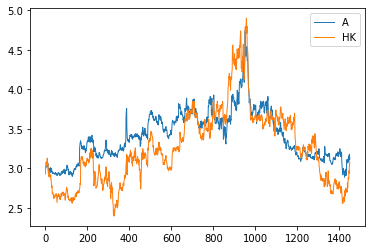

In [11]:
# df_ex = pro.fx_obasic(exchange='FXCM', classify='FX')
# df_ex.to_excel('data/汇率列表.xlsx')
# df_CNY = pro.fx_daily(ts_code='USDCNH.FXCM', start_date=start_date, end_date=end_date)
# df_HKD = pro.fx_daily(ts_code='USDHKD.FXCM', start_date=start_date, end_date=end_date)
# feature_list_ex = ['trade_date', 'ask_close']